# Part 1: Segmentation of hands

In this part, you are given a sequence of video frames in which a person is playing the piano with both hands. Try to develop an algorithm to identify the pianist's hands. Portions of the hands are sometimes in deep shadow, which creates a challenging imaging situation.

In [292]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
from os import listdir, makedirs
from os.path import isfile, join, abspath, exists

In [293]:
# read data
data_path = abspath('./CS585-PianoImages')
data_list = [join(data_path, file) for file in listdir(data_path) if isfile(join(data_path, file)) and 'png' in file]

In [294]:
data_list

['C:\\Users\\ljsPC\\Desktop\\CS585\\HW4\\HW4-CS585\\CS585-PianoImages\\piano_14.png',
 'C:\\Users\\ljsPC\\Desktop\\CS585\\HW4\\HW4-CS585\\CS585-PianoImages\\piano_15.png',
 'C:\\Users\\ljsPC\\Desktop\\CS585\\HW4\\HW4-CS585\\CS585-PianoImages\\piano_16.png',
 'C:\\Users\\ljsPC\\Desktop\\CS585\\HW4\\HW4-CS585\\CS585-PianoImages\\piano_17.png',
 'C:\\Users\\ljsPC\\Desktop\\CS585\\HW4\\HW4-CS585\\CS585-PianoImages\\piano_18.png',
 'C:\\Users\\ljsPC\\Desktop\\CS585\\HW4\\HW4-CS585\\CS585-PianoImages\\piano_19.png',
 'C:\\Users\\ljsPC\\Desktop\\CS585\\HW4\\HW4-CS585\\CS585-PianoImages\\piano_22.png',
 'C:\\Users\\ljsPC\\Desktop\\CS585\\HW4\\HW4-CS585\\CS585-PianoImages\\piano_23.png',
 'C:\\Users\\ljsPC\\Desktop\\CS585\\HW4\\HW4-CS585\\CS585-PianoImages\\piano_24.png',
 'C:\\Users\\ljsPC\\Desktop\\CS585\\HW4\\HW4-CS585\\CS585-PianoImages\\piano_25.png',
 'C:\\Users\\ljsPC\\Desktop\\CS585\\HW4\\HW4-CS585\\CS585-PianoImages\\piano_26.png',
 'C:\\Users\\ljsPC\\Desktop\\CS585\\HW4\\HW4-CS585\\CS

In [295]:
data_frames = []

for file in data_list:
    img = cv2.imread(file)
    data_frames.append(img.copy())
    
    img_grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
data_frames = np.array(data_frames)

## compute the average value of all image frames

In [296]:
avg_img = np.sum(data_frames, axis=0)


avg_img = avg_img / data_frames.shape[0]
avg_img = avg_img.astype(np.uint8)

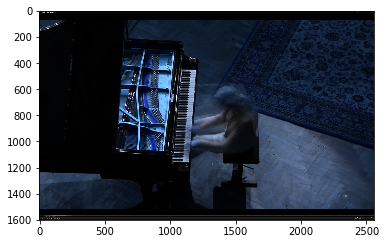

In [297]:
plt.imshow(avg_img)
plt.show()

## Difference the frames

In [298]:
motions = []

for frame in data_frames:
    diff = cv2.absdiff(frame, avg_img)
    diff_grayscale = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
    
    boolean_filter = diff_grayscale > 5
    motion = np.zeros_like(frame)
    motion[boolean_filter] = frame[boolean_filter]
    motions.append(motion)
    
motions = np.array(motions)

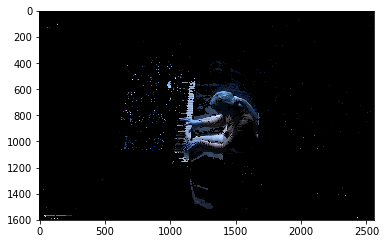

In [299]:
plt.imshow(motions[0])
plt.show()

## Skin Color Detection

In [300]:
# returns the @param img with only skin color (the rest of the pixels are black)
def skinDetect(img):
    B = img[:, :, 0]
    G = img[:, :, 1]
    R = img[:, :, 2]
    skin = np.zeros_like(img)
    maxMat = imgMax(img)
    minMat = imgMin(img)
    
    cond = (R > 100) & (B > 50) & (B < 130) & (G > 70) & ((maxMat - minMat) > 50) & (np.abs(R - G) > 40) & (R > G) & (R > B)
    skin[cond] = img[cond]
    return skin

def imgMax(img):
    maxMat = np.max(img.reshape(img.shape[0]*img.shape[1], 3), axis=1).reshape(img.shape[0], img.shape[1])
    return maxMat

def imgMin(img):
    minMat = np.min(img.reshape(img.shape[0]*img.shape[1], 3), axis=1).reshape(img.shape[0], img.shape[1])
    return minMat

In [301]:
skin_imgs = []
for img in motions:
    skin_imgs.append(skinDetect(img))

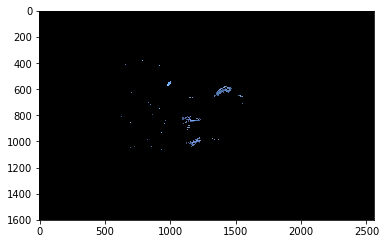

In [302]:
plt.imshow(skin_imgs[6])
plt.show()

## Find Hand Positions

In [303]:
# return the bounding boxes of the largest three blobs
def three_largest_blobs(grayscale_img):
    _, contours_opencv, hierarchy = cv2.findContours(grayscale_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # choose the largest size object
    largest_three_area = [0,0,0]
    largest_three_index = [0,0,0]
    for index in range(len(contours_opencv)):
        area = cv2.contourArea(contours_opencv[index])
        if area > np.min(largest_three_area):
            largest_three_index[np.argmin(largest_three_area)] = index
            largest_three_area[np.argmin(largest_three_area)] = area 

    bounding_boxes = []
    for index in largest_three_index:
        x, y, w, h = cv2.boundingRect(contours_opencv[index])
        bounding_boxes.append([x, y, w, h])
    
    return bounding_boxes, largest_three_area

In [304]:
bounding_boxes = []
largest_three_areas = []
for skin_img in skin_imgs:
    img_skin_grayscale = cv2.cvtColor(skin_img, cv2.COLOR_BGR2GRAY)
    
    largest_three__boxes, largest_three_area = three_largest_blobs(img_skin_grayscale)
    bounding_boxes.append(largest_three__boxes)
    largest_three_areas.append(largest_three_area)

print(bounding_boxes, largest_three_areas)

[[[1118, 840, 129, 35], [1316, 624, 153, 86], [1110, 982, 127, 65]], [[1120, 880, 113, 39], [1342, 579, 142, 86], [1110, 1000, 122, 34]], [[1134, 985, 93, 48], [1120, 856, 104, 43], [1363, 577, 121, 76]], [[1109, 825, 131, 52], [1350, 579, 147, 78], [1109, 996, 127, 50]], [[1137, 988, 99, 53], [1316, 590, 163, 95], [1115, 871, 114, 40]], [[1134, 991, 98, 48], [1108, 870, 118, 40], [1316, 588, 163, 95]], [[1118, 990, 119, 52], [1350, 581, 128, 76], [1102, 826, 134, 42]], [[1346, 583, 139, 78], [1105, 872, 129, 43], [1110, 1012, 136, 42]], [[1117, 874, 114, 40], [1374, 570, 135, 79], [1114, 1001, 123, 34]], [[1099, 879, 139, 45], [1384, 559, 135, 77], [1111, 998, 125, 35]], [[1372, 553, 138, 77], [1145, 983, 94, 53], [1107, 845, 128, 45]], [[1108, 990, 121, 40], [1361, 562, 136, 87], [1064, 866, 162, 47]], [[1281, 442, 132, 69], [1199, 650, 44, 14], [1123, 639, 124, 78]], [[1150, 548, 112, 43], [1294, 389, 125, 65], [1138, 594, 110, 71]], [[1124, 736, 117, 40], [1121, 788, 126, 70], [127

In [305]:
# two hands and the head are detected
# exclude head blob
for index in range(len(bounding_boxes)):
    x_max = 0
    max_index = 0
    for blob_index in range(len(bounding_boxes[index])):
        if bounding_boxes[index][blob_index][0] > x_max:
            x_max = bounding_boxes[index][blob_index][0]
            max_index = blob_index
    del bounding_boxes[index][max_index]
    del largest_three_areas[index][max_index]

bounding_boxes = np.array(bounding_boxes)
largest_three_areas = np.array(largest_three_areas)
bounding_boxes

array([[[1118,  840,  129,   35],
        [1110,  982,  127,   65]],

       [[1120,  880,  113,   39],
        [1110, 1000,  122,   34]],

       [[1134,  985,   93,   48],
        [1120,  856,  104,   43]],

       [[1109,  825,  131,   52],
        [1109,  996,  127,   50]],

       [[1137,  988,   99,   53],
        [1115,  871,  114,   40]],

       [[1134,  991,   98,   48],
        [1108,  870,  118,   40]],

       [[1118,  990,  119,   52],
        [1102,  826,  134,   42]],

       [[1105,  872,  129,   43],
        [1110, 1012,  136,   42]],

       [[1117,  874,  114,   40],
        [1114, 1001,  123,   34]],

       [[1099,  879,  139,   45],
        [1111,  998,  125,   35]],

       [[1145,  983,   94,   53],
        [1107,  845,  128,   45]],

       [[1108,  990,  121,   40],
        [1064,  866,  162,   47]],

       [[1199,  650,   44,   14],
        [1123,  639,  124,   78]],

       [[1150,  548,  112,   43],
        [1138,  594,  110,   71]],

       [[1124,  736,

In [306]:
# draw bounding box for each image
blob_area_threshold = 500

for img_index in range(data_frames.shape[0]):
    for bounding_box_index in range(bounding_boxes[img_index].shape[0]):
        x, y, w, h = bounding_boxes[img_index][bounding_box_index]
       
        # two hands are separated
        if np.min(largest_three_areas[img_index]) > blob_area_threshold:
            # left hand at the bottom
            if y == np.max(bounding_boxes[img_index][:,1]):
                cv2.rectangle(data_frames[img_index], (x, y), (x + w, y + h), (0, 255, 0), 5, 8, 0)
                cv2.putText(data_frames[img_index], 'left hand', (x, y),cv2.FONT_HERSHEY_PLAIN,2,(0,255,0), 2)
            # right hand
            else:
                cv2.rectangle(data_frames[img_index], (x, y), (x + w, y + h), (0, 0, 255), 5, 8, 0)
                cv2.putText(data_frames[img_index], 'right hand', (x, y),cv2.FONT_HERSHEY_PLAIN,2,(0,0,255), 2)
        # two hands are overlapped
        elif largest_three_areas[img_index][bounding_box_index] > blob_area_threshold:
            cv2.rectangle(data_frames[img_index], (x, y), (x + w, y + h), (0, 255, 0), 5, 8, 0)
            cv2.putText(data_frames[img_index], 'overlapped hand', (x, y),cv2.FONT_HERSHEY_PLAIN,2,(255,0,0), 2)  


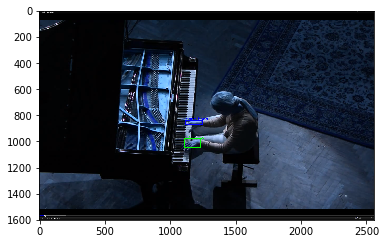

In [307]:
plt.imshow(data_frames[0])
plt.show()

## Save the output images

In [308]:
# write the image to the output file
if not exists('./output'):
    makedirs('./output')

count = 1
for output in data_frames:
    cv2.imwrite('./output/'+str(count)+'.jpeg',output)
    count += 1